In [1]:
import os

# Install git if not already installed
!apt-get install -y git

# Clone the repository
!git clone https://github.com/jidhu-mohan/Defect-Detection-of-PCB.git

# Change working directory to the repository
%cd Defect-Detection-of-PCB

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Cloning into 'Defect-Detection-of-PCB'...
remote: Enumerating objects: 1263, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 1263 (delta 28), reused 43 (delta 22), pack-reused 1213 (from 1)
Receiving objects: 100% (1263/1263), 83.95 MiB | 11.54 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (1305/1305), done.
/content/Defect-Detection-of-PCB


In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [3]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [4]:
'''                                                            # I trained it on Google Colab, so it's of no use in Local drive.
from google.colab import drive
drive.mount('/content/drive')
'''

"                                                            # I trained it on Google Colab, so it's of no use in Local drive.\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [5]:
filenames = os.listdir(r"dataset/train/train5/")
labels = []

for filename in filenames:
    label = filename.split(' ')[0]
    if label == 'good':
        labels.append(0)
    else:
        labels.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

In [6]:
df.head(1000)

,filename,label
0,bad (135)k.jpeg,1
1,good (31)k.jpeg,0
2,bad (282)k.jpeg,1
3,good (555)k.jpeg,0
4,good (563)k.jpeg,0
...,...,...
995,bad (200)k.jpeg,1
996,good (3)k.jpeg,0
997,good (368)k.jpeg,0
998,good (34)k.jpeg,0


<Axes: xlabel='label'>

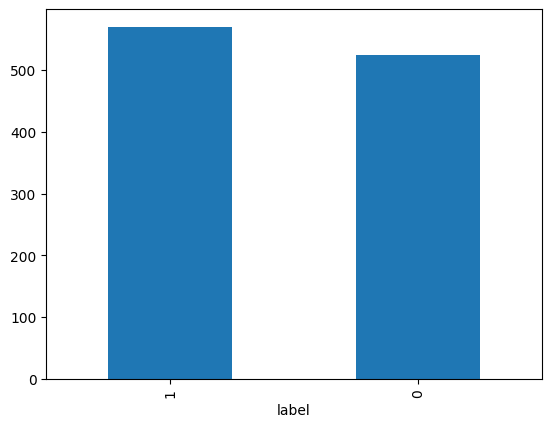

In [7]:
df['label'].value_counts().plot.bar()

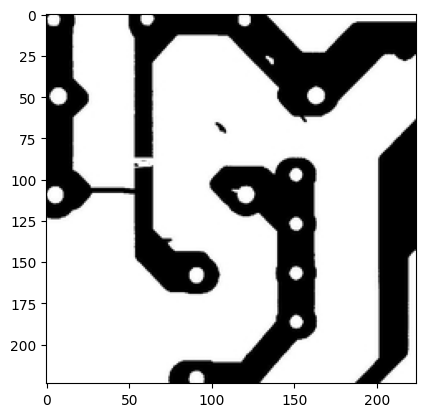

In [8]:
sample = random.choice(filenames)
image = load_img(r"dataset/train/train5/"+sample)
plt.imshow(image)

In [9]:
base_model=MobileNet(weights='imagenet',include_top=False)  #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)                          #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x)                          #dense layer 2
x=Dense(512,activation='relu')(x)                           #dense layer 3
preds=Dense(2,activation='softmax')(x)                      #final layer with softmax activation

<ipython-input-9-74e404866431>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNet(weights='imagenet',include_top=False)  #imports the mobilenet model and discards the last 1000 neuron layer.


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model=Model(inputs=base_model.input,outputs=preds)

In [11]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [13]:
earlystop = EarlyStopping(patience=10)

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [15]:
callbacks = [earlystop, learning_rate_reduction]

In [16]:
df["label"] = df["label"].replace({0: 'Good', 1: 'Bad'})

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='label'>

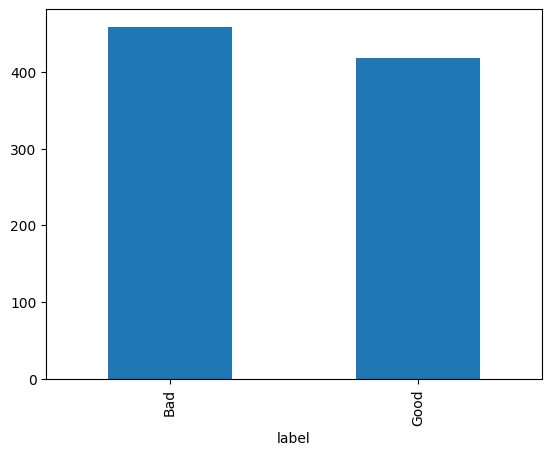

In [18]:
train_df['label'].value_counts().plot.bar()

<Axes: xlabel='label'>

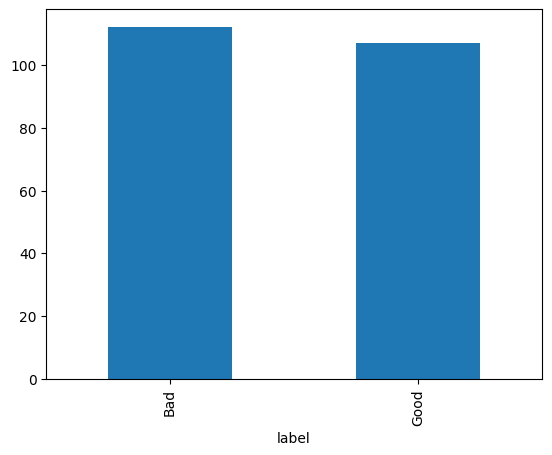

In [19]:
validate_df['label'].value_counts().plot.bar()

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    r"dataset/train/train5/",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 876 validated image filenames belonging to 2 classes.


In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    r"dataset/train/train5/",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 219 validated image filenames belonging to 2 classes.


In [23]:
# epochs=3 if FAST_RUN else 50
# history = model.fit_generator(
#     train_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate//batch_size,
#     steps_per_epoch=total_train//batch_size,
#     callbacks=callbacks
# )

In [24]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 392ms/step - accuracy: 0.5940 - loss: 1.0345 - val_accuracy: 0.8190 - val_loss: 0.9491 - learning_rate: 0.0010
Epoch 2/50
 1/58 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8667 - loss: 0.3991

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8667 - loss: 0.3991 - val_accuracy: 1.0000 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 197ms/step - accuracy: 0.9124 - loss: 0.2722 - val_accuracy: 0.9286 - val_loss: 0.4027 - learning_rate: 0.0010
Epoch 4/50
 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9333 - loss: 0.2624
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.9333 - loss: 0.2624 - val_accuracy: 1.0000 - val_loss: 8.1508e-04 - learning_rate: 0.0010
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.9300 - loss: 0.1906 - val_accuracy: 0.9190 - val_loss: 0.3080 - learning_rate: 5.0000e-04
Epoch 6/50
 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 1.0000 - loss: 0.0414
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0414 - val_accu

In [26]:
model.save("model.h5")

In [27]:
# model.save('model.h5')

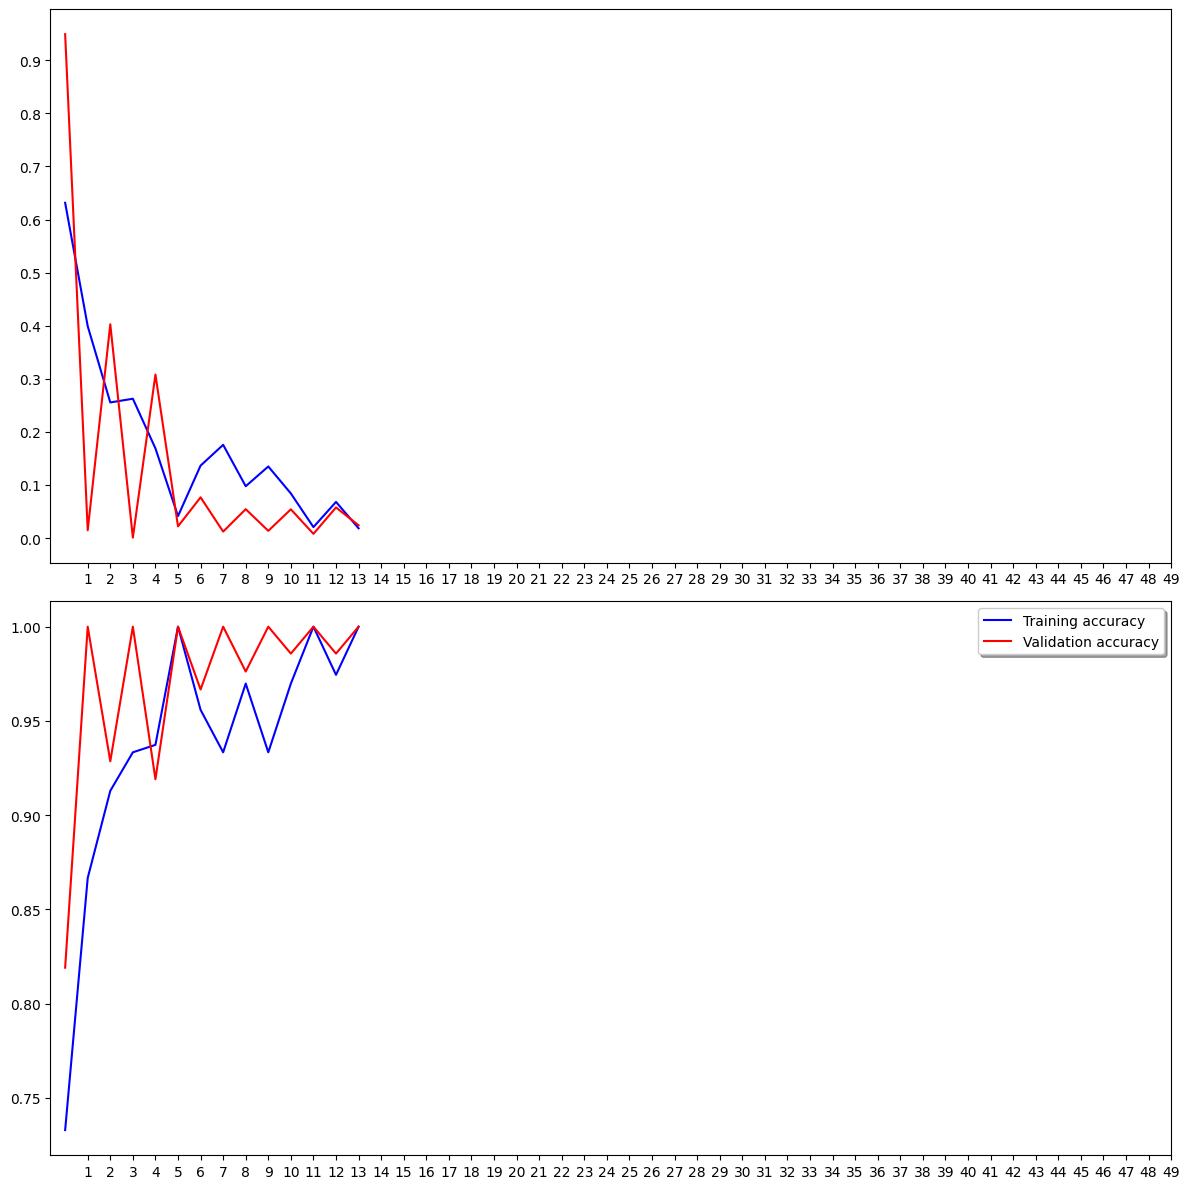

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [30]:
model = load_model(r'model.h5')

In [31]:
import cv2
img = cv2.imread(r'dataset/test/test5/good (371)k.jpeg')
img = img[...,::-1]                                                                 #give right image or else it will show error
model.predict(img[None,...], batch_size=None, verbose=2, steps=1)

1/1 - 3s - 3s/step


array([[0.9472421, 0.0527579]], dtype=float32)

In [32]:
test_filenames = os.listdir(r"dataset/test/test5/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [33]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    r"dataset/test/test5/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


In [35]:
predict = model.predict(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 490ms/step


In [36]:
test_df['label'] = np.argmax(predict, axis=-1)

In [37]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)

<Axes: xlabel='label'>

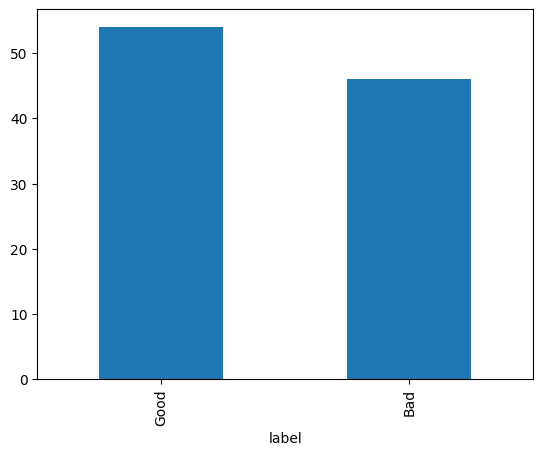

In [38]:
test_df['label'].value_counts().plot.bar()

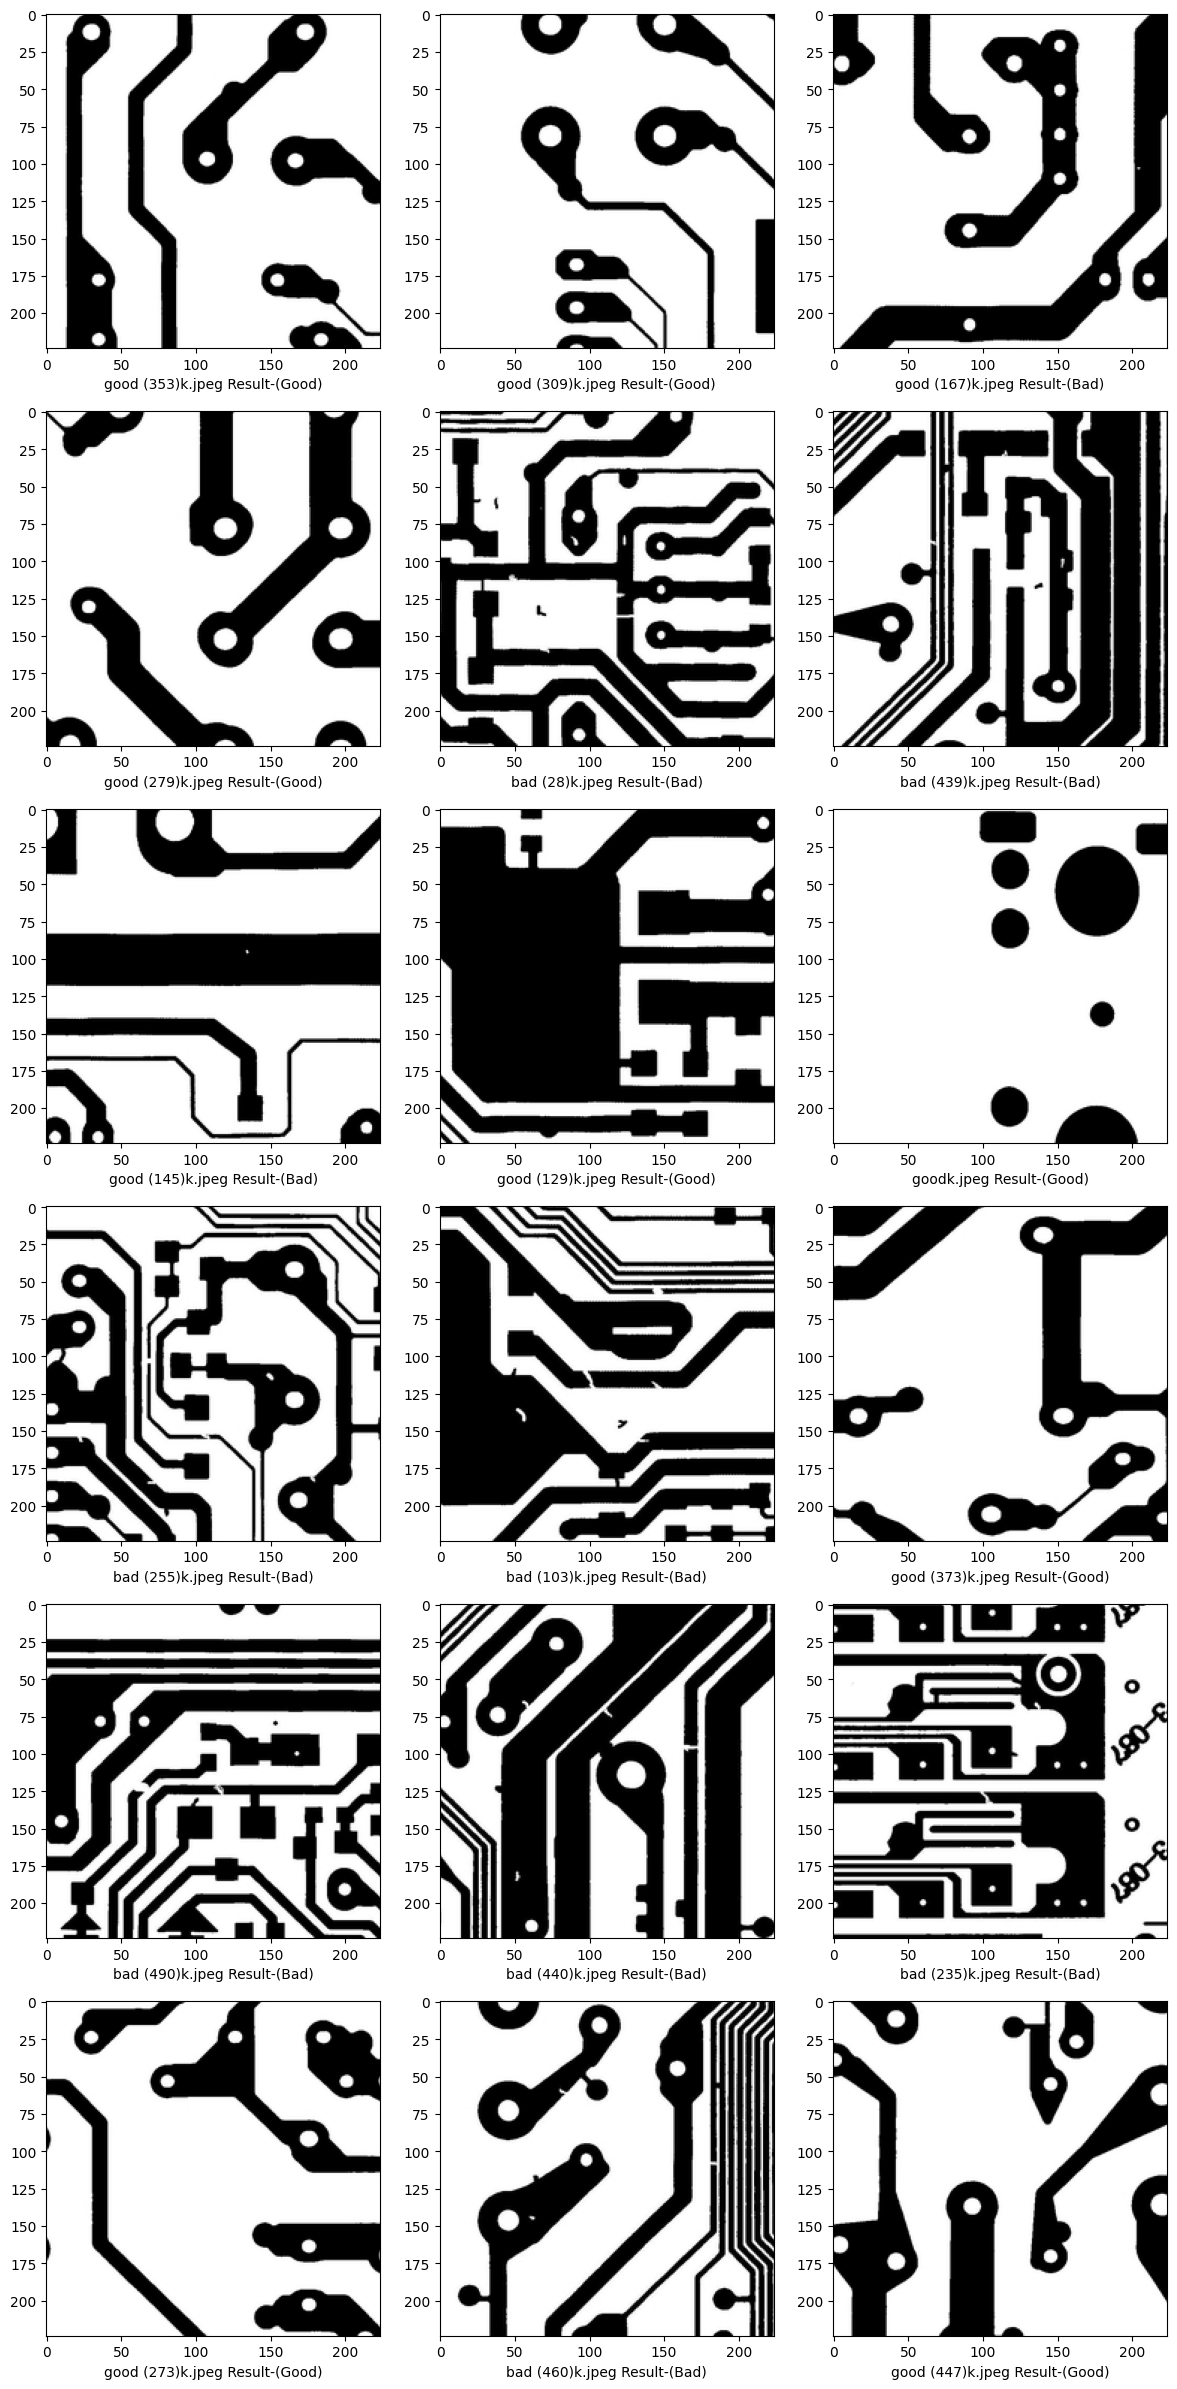

In [39]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['label']
    img = load_img(r"dataset/test/test5/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + (' ') + 'Result-' + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()